<a href="https://colab.research.google.com/github/robertobruzzese/article-lab/blob/main/Progetto_fiverr_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import torch # PyTorch package
import torchvision # load datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
# torchvision for pre-trained models
from torchvision import models

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision.transforms as transforms #  augment data
import torch.nn as nn #  building  neural neteorks
import torch.nn.functional as F #  convolution functions like Relu
import torch.optim as optim # optimzer 
from torchsummary import summary

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings #Ability to create custom warnings, like warnings.warn("deprecated", DeprecationWarning)
import itertools #Needed for Confusion Matrix

In [2]:
def PlotCategoricalMetrics(Y_Hat, Targets, ClassNames, Normalise, figsize = None):
    """Plots the Confusion matrix given the class index (0 to K-1), and the Actual values."""
    PrevFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize if figsize is not None else PrevFigSize
    
    sk_conf_matrx = confusion_matrix(Targets, Y_Hat)
    plot_confusion_matrix(sk_conf_matrx, ClassNames, Normalise = Normalise)
    
    plt.rcParams['figure.figsize'] = PrevFigSize

In [3]:
def plot_confusion_matrix(sk_conf_matrx, Classes, Normalise = False, Title = 'Confusion matrix', Colourmap = plt.cm.Blues):
    """Plot the Confusion Matrix object returned by sklearn's confusion_matrix() and Normalise it if Normalise==True."""
    plt.grid(False)
    if Normalise:
        print('Confusion matrix')
        print(sk_conf_matrx)
        sk_conf_matrx = sk_conf_matrx.astype('float') / sk_conf_matrx.sum(axis = 1)[:, np.newaxis]
        plt.imshow(sk_conf_matrx, interpolation = 'nearest', cmap = Colourmap)
        plt.clim(0.0, 1.0)
    else:
        plt.imshow(sk_conf_matrx, interpolation = 'nearest', cmap = Colourmap)
    plt.title(Title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.colorbar()
    tick_marks = np.arange(len(Classes))
    plt.xticks(tick_marks, Classes, rotation = 45)
    plt.yticks(tick_marks, Classes)
    
    fmt = '.2f' if Normalise else 'd'
    thresh = sk_conf_matrx.max() / 2.
    for i, j in itertools.product(range(sk_conf_matrx.shape[0]), range(sk_conf_matrx.shape[1])):
        plt.text(j, i, format(sk_conf_matrx[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if sk_conf_matrx[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
train_root='./dataset_9010/dataset_9010/malimg_dataset/train'
val_root='./validation_ds_update_924/validation_ds_update_924/malimg_dataset/validation'

In [5]:
data_aug_transforms = [
     transforms.RandomHorizontalFlip(), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomAffine(degrees=75),
     transforms.RandomAffine(degrees=0,translate=(0.5,0.5)),
     transforms.RandomAffine(degrees=0,scale=(0.7,0.7))
 ]

In [6]:
from google.colab import drive

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd '/content/drive/MyDrive/AML_DATA/'

/content/drive/.shortcut-targets-by-id/1PHQ0lh7VNfUJjD9R69bWwquzSpqaGt3s/AML_DATA


In [9]:
img_size=(64, 64)

data_transform=transforms.Compose(
   [ transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
   ])
# mean and std are calculated from the ImageNet images



orig_set = torchvision.datasets.ImageFolder(root=train_root , transform=data_transform )
val_= torchvision.datasets.ImageFolder(root=val_root )


n = len(orig_set)  # total number of examples


print(f'Number of original examples: {len(orig_set)}')
print(f'Number of Validation examples: {len(val_)}')

print("Number of classes in training set : \n", len(orig_set.classes))
print("The following classes are in training set : \n",orig_set.classes)

Number of original examples: 8404
Number of Validation examples: 924
Number of classes in training set : 
 25
The following classes are in training set : 
 ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


In [10]:
train_dataset = torchvision.datasets.ImageFolder(root=train_root , transform=data_transform )
val_dataset = torchvision.datasets.ImageFolder(root=val_root , transform=data_transform)

print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of Validation examples: {len(val_dataset)}')

batch_size = 128
train_loader=DataLoader(train_dataset,batch_size=batch_size , shuffle=True )
val_loader=DataLoader(val_dataset,batch_size=batch_size ,shuffle=False)

Number of training examples: 8404
Number of Validation examples: 924


In [11]:
pip install einops

In [12]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable
from einops import rearrange
from einops.layers.torch import Rearrange


def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)


class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=3)


def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(1, 3, 224, 224)

    net = coatnet_0()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_1()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_2()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_3()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_4()
    out = net(img)
    print(out.shape, count_parameters(net))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3]) 17023928
torch.Size([1, 1000]) 33170624
torch.Size([1, 1000]) 55767564
torch.Size([1, 1000]) 117724480
torch.Size([1, 1000]) 203960368


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


input_size = 3
num_classes = 25
num_epochs = 2
batch_size = 128
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 8404
num_validation =924


# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
accuracy_val = []
train_acc_curve=[]


num_blocks = [2, 2, 6, 8, 2]
channels = [16, 32, 64, 128, 256]
block_types = ['C', 'C', 'T', 'T']

model_ = CoAtNet((64,64),3,num_blocks=num_blocks, channels=channels, block_types=block_types, num_classes=25).to(device)

optimizer = torch.optim.Adam(model_.parameters(), lr=learning_rate, weight_decay=reg)
criterion = nn.CrossEntropyLoss()

Using device: cpu


In [14]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Training accuracy is: 78.33174678724417 %
Validation accuracy is: 91.55844155844156 %
Training accuracy is: 96.52546406473108 %
Validation accuracy is: 92.64069264069263 %


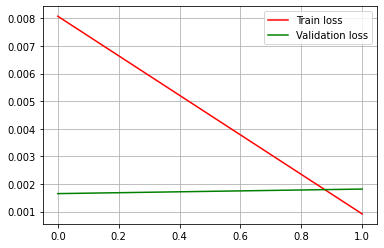

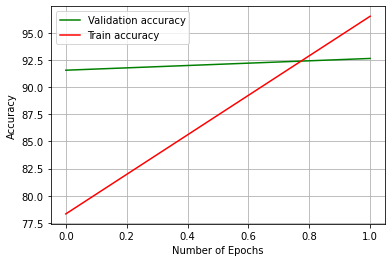

In [15]:
for epoch in range(num_epochs):
    correct = 0
    total = 0

    model_.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ###
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        ###

        loss_iter += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_train.append(loss_iter/(len(train_loader)*batch_size))
    
    ###
    _train_acc = 100 * correct / total
    train_acc_curve.append(_train_acc)
    print('Training accuracy is: {} %'.format(_train_acc))
    ###


    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    
    
     
    model_.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        print('Validation accuracy is: {} %'.format(accuracy))
        


    


model_.eval()



plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Validation loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(3)
plt.plot(accuracy_val, 'g', label='Validation accuracy')
plt.plot(train_acc_curve, 'r', label='Train accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# loading the pretrained model vgg16
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [17]:
# Freeze model vgg16 weights
for param in model.parameters():
    param.requires_grad = False

In [18]:
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()

In [19]:
# Add on classifier
model.classifier[6] = Sequential(
                      Linear(4096, 25))
for param in model.classifier[6].parameters():
    param.requires_grad = True
#print(model.classifier.parameters) 
#print(model)
print(model.features)   

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

# Nuova sezione

# Nuova sezione

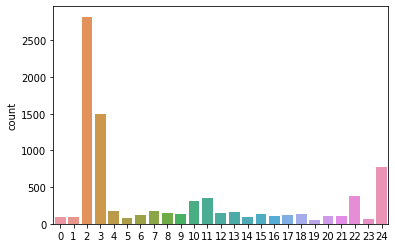

In [20]:
import seaborn as sns
sns.countplot(x = train_dataset.targets)
plt.show()

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

input_size = 3
num_classes = 25
num_epochs = 6
batch_size = 128
learning_rate = 5e-4
learning_rate_decay = 0.98
reg = 0.20
num_training= 8404
num_validation = 924

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
accuracy_val = []
train_acc_curve=[]

Using device: cpu


In [22]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
# loading the pretrained model vgg16
model = models.vgg16_bn(pretrained=True)

In [24]:
# Freeze model vgg16 weights
for param in model.parameters():
    param.requires_grad = False

In [25]:
# Add on classifier
# model.classifier[6] = Sequential(
#                       Linear(4096, 8192),
#                       Dropout(0.5),
#                       Linear(8192, 25)
#                       )
model.classifier[6] = Sequential(
                      Linear(4096, 25)
                      )
for param in model.classifier[6].parameters():
    param.requires_grad = True
#print(model.classifier.parameters) 
print(model)
# print(model.features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
criterion = nn.CrossEntropyLoss()

  2%|▏         | 1/66 [00:01<01:07,  1.03s/it]

 Epoch [1/6], Step [1/66], Loss: 3.3054


 76%|███████▌  | 50/66 [00:56<00:19,  1.22s/it]

 Epoch [1/6], Step [50/66], Loss: 0.7476


Epoch [1/6]. Train: Loss 0.0089, Acc 65.64 | Valid: Loss 0.0054, Acc 80.09



  2%|▏         | 1/66 [00:01<01:08,  1.05s/it]

 Epoch [2/6], Step [1/66], Loss: 0.5265


 76%|███████▌  | 50/66 [00:54<00:17,  1.07s/it]

 Epoch [2/6], Step [50/66], Loss: 0.8089


Epoch [2/6]. Train: Loss 0.0052, Acc 80.65 | Valid: Loss 0.0049, Acc 83.12



  2%|▏         | 1/66 [00:01<01:06,  1.03s/it]

 Epoch [3/6], Step [1/66], Loss: 0.5728


 76%|███████▌  | 50/66 [00:52<00:16,  1.04s/it]

 Epoch [3/6], Step [50/66], Loss: 0.6482


Epoch [3/6]. Train: Loss 0.0049, Acc 82.33 | Valid: Loss 0.0049, Acc 83.23



  2%|▏         | 1/66 [00:01<01:05,  1.00s/it]

 Epoch [4/6], Step [1/66], Loss: 0.6953


 76%|███████▌  | 50/66 [00:52<00:16,  1.03s/it]

 Epoch [4/6], Step [50/66], Loss: 0.6096


Epoch [4/6]. Train: Loss 0.0048, Acc 82.65 | Valid: Loss 0.0049, Acc 82.47



  2%|▏         | 1/66 [00:00<01:00,  1.08it/s]

 Epoch [5/6], Step [1/66], Loss: 0.6484


 76%|███████▌  | 50/66 [00:51<00:16,  1.04s/it]

 Epoch [5/6], Step [50/66], Loss: 0.5500


Epoch [5/6]. Train: Loss 0.0046, Acc 83.58 | Valid: Loss 0.0044, Acc 84.31



  2%|▏         | 1/66 [00:00<01:01,  1.06it/s]

 Epoch [6/6], Step [1/66], Loss: 0.5825


 76%|███████▌  | 50/66 [00:50<00:16,  1.00s/it]

 Epoch [6/6], Step [50/66], Loss: 0.7729


Epoch [6/6]. Train: Loss 0.0046, Acc 82.97 | Valid: Loss 0.0047, Acc 83.33



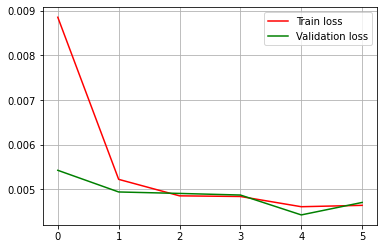

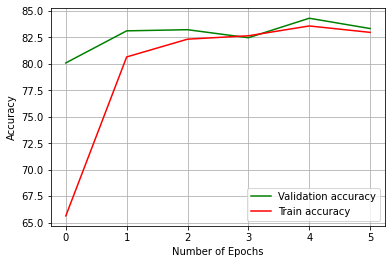

Confusion matrix
[[ 25   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0  23   1   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0 110   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0  49  51   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   1  24   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  25]
 [  0   0   3   0   0   0  20   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  22   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0  25   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 

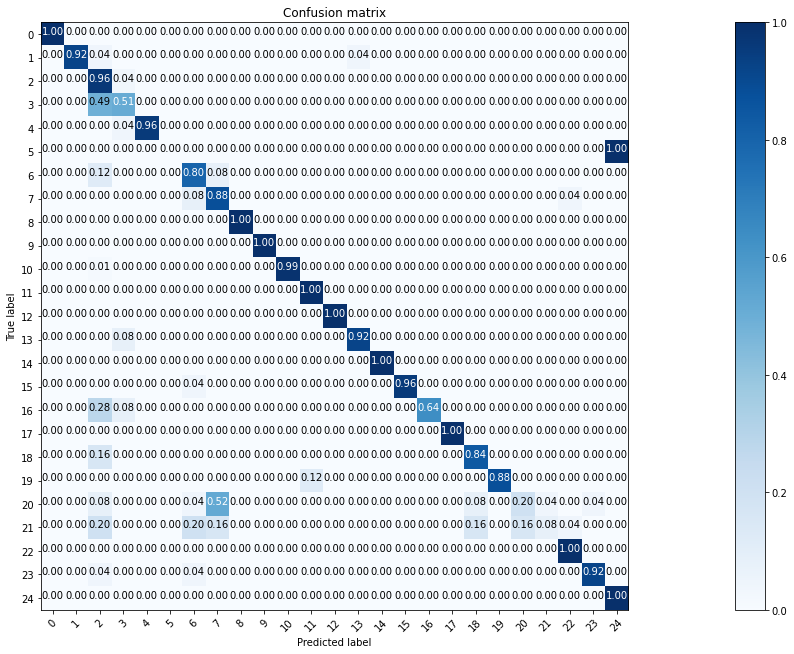

In [27]:
PrintEveryN = 1
for epoch in range(num_epochs):
    correct = 0
    total = 0

    model.to(device)
    model.train()

    loss_iter = 0
    for i, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader), leave = False):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss_iter += loss.item()
        if i == 0 or (i+1) % 50 == 0:
            print (' Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
    loss_train.append(loss_iter/(len(train_loader)*batch_size))
    
    ###
    _train_acc = 100 * correct / total
    train_acc_curve.append(_train_acc)
    ###

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in tqdm(val_loader, total = len(val_loader), leave = False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
            targets.append(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    if epoch == 0 or (epoch+1) % PrintEveryN == 0 or (epoch+1) == num_epochs:
        print ('Epoch [{}/{}]. Train: Loss {:.4f}, Acc {:.2f} | Valid: Loss {:.4f}, Acc {:.2f}\n'.format(epoch+1, num_epochs, loss_train[-1], _train_acc, loss_val[-1], accuracy))

model.eval()

plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Validation loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(3)
plt.plot(accuracy_val, 'g', label='Validation accuracy')
plt.plot(train_acc_curve, 'r', label='Train accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Viewing the overall Categorical metrics and Plotting the Confusion Matrix
PlotCategoricalMetrics(predictions, targets, range(25), Normalise = True, figsize = [30, 9])